### ALZHEIMER

In [1]:
import pandas as pd 

data = pd.read_csv('C:\\Users\\lclai\\Desktop\\data_dementia\\clean\\alzheimer.csv')

In [2]:
df_alzheimer = data[data['ALZHEIMER'] == 1]
df_no_alzheimer = data[data['ALZHEIMER'] == 0]

df_no_alzheimer_sampled = pd.DataFrame()

for (age, gender), group in df_alzheimer.groupby(['AGE', 'GENDER']):
 
    matched_controls = df_no_alzheimer[(df_no_alzheimer['AGE'] == age) & (df_no_alzheimer['GENDER'] == gender)]
    
    if len(matched_controls) > len(group):
        matched_controls = matched_controls.sample(n=len(group), random_state=42)
    
    df_no_alzheimer_sampled = pd.concat([df_no_alzheimer_sampled, matched_controls])

df_balanced = pd.concat([df_alzheimer, df_no_alzheimer_sampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_balanced = remove_outliers_iqr(df_balanced, 'AGE')
df_balanced = remove_outliers_iqr(df_balanced, 'LAST_ADMISSION_LENGTH')

In [4]:
binary = ['GENDER', 'ALZHEIMER', 'HYPERTENSION',
       'CORONARY_ATHEROSCLEROSIS', 'ATRIAL_FIBRILLATION', 'HEART_FAILURE',
       'KIDNEY_FAILURE', 'HYPERLIPIDEMIA', 'DIABETES', 'RESPIRATORY_FAILURE',
       'UTI', 'PROPHYLAXIS_VIRAL_HEPATITIS', 'OBSERVATION_INFECTIOUS',
       'HYPERCHOLESTEROLEMIA', 'ESOPHAGEAL_REFLUX', 'ANEMIA', 'PNEUMONIA',
       'POSTHEMORRHAGIC_ANEMIA', 'ACIDOSIS', 'LAST_ADMISSION_LENGTH',
       'ETHNICITY', 'MARITAL_STATUS', 'POTASSIUM_CHLORIDE',
       'SODIUM_CHLORIDE_FLUSH', 'ACETAMINOPHEN', 'MAGNESIUM_SULFATE',
       'INSULIN', 'HEPARIN', 'DOCUSATE_SODIUM', 'D5W', 'ISO_OSMOTIC_DEXTROSE',
       'MORPHINE_SULFATE', 'NS', 'SW', 'FUROSEMIDE', 'CALCIUM_GLUCONATE',
       'BISACODYL']
categorical = ['ETHNICITY','MARITAL_STATUS']
numerical = ['LAST_ADMISSION_LENGTH','AGE']

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
scaler = StandardScaler()

for col in binary + categorical:
    df_balanced[col] = le.fit_transform(df_balanced[col]) 

df_balanced[numerical] = scaler.fit_transform(df_balanced[numerical])

In [7]:
from sklearn.model_selection import train_test_split

y = df_balanced['ALZHEIMER']  
X = df_balanced.drop(columns=['ALZHEIMER']) 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,  StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [200, 500, 1000],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [False],  
    'max_samples': [None],  
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print("Best parameters found: ", rf_grid_search.best_params_)
print(f"Random Forest AUC: {rf_grid_search.best_score_}")

Best parameters found:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Random Forest AUC: 0.7454862334291276


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_proba = rf_grid_search.best_estimator_.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc}")

AUC: 0.7518655840803493


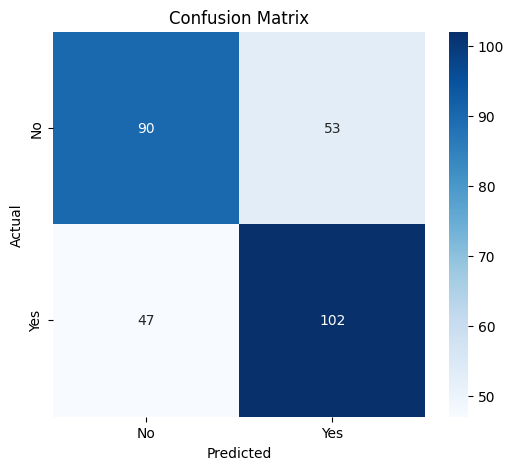

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       143
           1       0.66      0.68      0.67       149

    accuracy                           0.66       292
   macro avg       0.66      0.66      0.66       292
weighted avg       0.66      0.66      0.66       292

AUC: 0.7518655840803493


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_proba = rf_grid_search.best_estimator_.predict_proba(X_test)[:, 1]  

y_pred = (y_proba >= 0.5).astype(int)  

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc}")


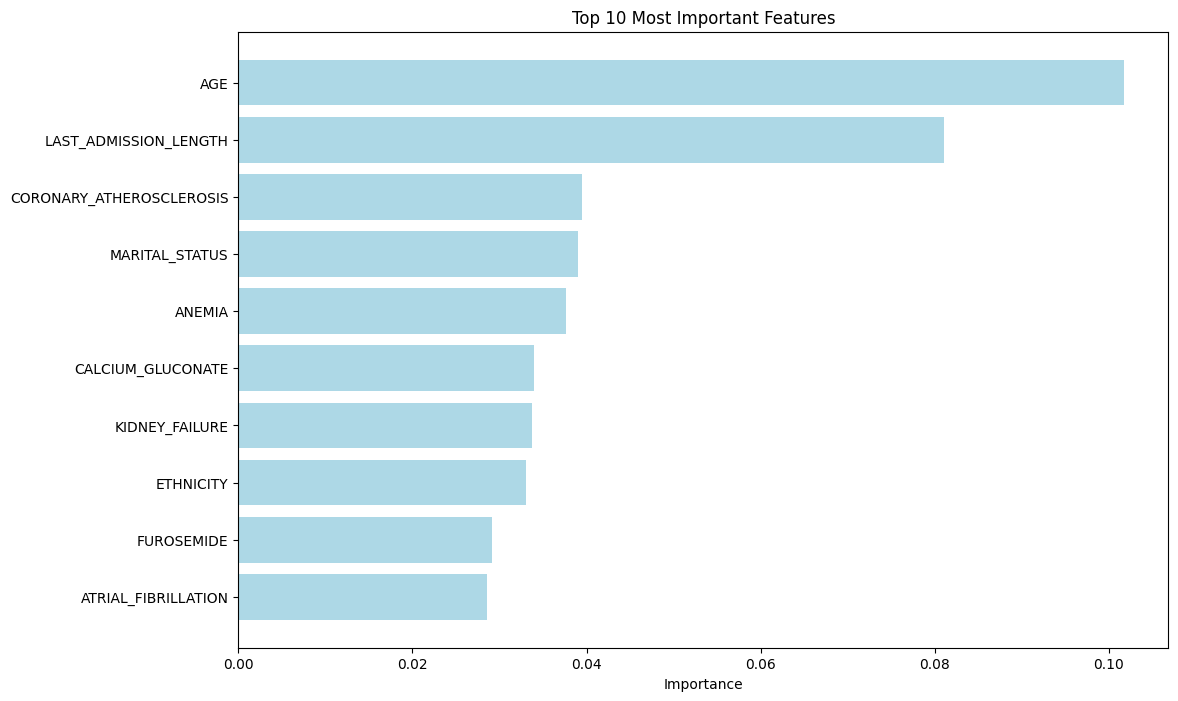

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = rf_grid_search.best_estimator_.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df.head(10)['Feature'], importance_df.head(10)['Importance'], color='lightblue')
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()

### ALL DEMENTIA TYPES

In [1]:
import pandas as pd 

data = pd.read_csv('C:\\Users\\lclai\\Desktop\\data_dementia\\clean\\dementia.csv')

df_alzheimer = data[data['DEMENTIA'] == 1]
df_no_alzheimer = data[data['DEMENTIA'] == 0]

df_no_alzheimer_sampled = pd.DataFrame()

for (age, gender), group in df_alzheimer.groupby(['AGE', 'GENDER']):
 
    matched_controls = df_no_alzheimer[(df_no_alzheimer['AGE'] == age) & (df_no_alzheimer['GENDER'] == gender)]
    
    if len(matched_controls) > len(group):
        matched_controls = matched_controls.sample(n=len(group), random_state=42)
    
    df_no_alzheimer_sampled = pd.concat([df_no_alzheimer_sampled, matched_controls])

df_balanced = pd.concat([df_alzheimer, df_no_alzheimer_sampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_balanced = remove_outliers_iqr(df_balanced, 'AGE')
df_balanced = remove_outliers_iqr(df_balanced, 'LAST_ADMISSION_LENGTH')

binary = ['GENDER', 'DEMENTIA', 'HYPERTENSION',
       'CORONARY_ATHEROSCLEROSIS', 'ATRIAL_FIBRILLATION', 'HEART_FAILURE',
       'KIDNEY_FAILURE', 'HYPERLIPIDEMIA', 'DIABETES', 'RESPIRATORY_FAILURE',
       'UTI', 'PROPHYLAXIS_VIRAL_HEPATITIS', 'OBSERVATION_INFECTIOUS',
       'HYPERCHOLESTEROLEMIA', 'ESOPHAGEAL_REFLUX', 'ANEMIA', 'PNEUMONIA',
       'POSTHEMORRHAGIC_ANEMIA', 'ACIDOSIS', 'LAST_ADMISSION_LENGTH',
       'ETHNICITY', 'MARITAL_STATUS', 'POTASSIUM_CHLORIDE',
       'SODIUM_CHLORIDE_FLUSH', 'ACETAMINOPHEN', 'MAGNESIUM_SULFATE',
       'INSULIN', 'HEPARIN', 'DOCUSATE_SODIUM', 'D5W', 'ISO_OSMOTIC_DEXTROSE',
       'MORPHINE_SULFATE', 'NS', 'SW', 'FUROSEMIDE', 'CALCIUM_GLUCONATE',
       'BISACODYL']
categorical = ['ETHNICITY','MARITAL_STATUS']
numerical = ['LAST_ADMISSION_LENGTH','AGE']

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
scaler = StandardScaler()

for col in binary + categorical:
    df_balanced[col] = le.fit_transform(df_balanced[col]) 

df_balanced[numerical] = scaler.fit_transform(df_balanced[numerical])

In [3]:
from sklearn.model_selection import train_test_split

y = df_balanced['DEMENTIA']  
X = df_balanced.drop(columns=['DEMENTIA']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,  StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [1000],  
    'max_depth': [20],  
    'min_samples_split': [2], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2']
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print("Best parameters found: ", rf_grid_search.best_params_)
print(f"Random Forest AUC: {rf_grid_search.best_score_}")

Best parameters found:  {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Random Forest AUC: 0.7917639419124077


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_proba = rf_grid_search.best_estimator_.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc}")

AUC: 0.8015464387256689


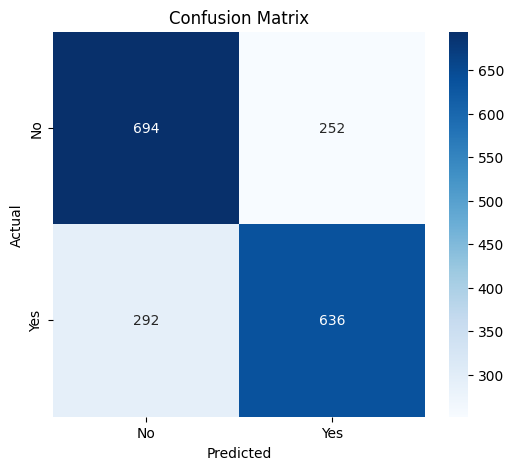

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       946
           1       0.72      0.69      0.70       928

    accuracy                           0.71      1874
   macro avg       0.71      0.71      0.71      1874
weighted avg       0.71      0.71      0.71      1874

AUC: 0.8015464387256689


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_proba = rf_grid_search.best_estimator_.predict_proba(X_test)[:, 1]  

y_pred = (y_proba >= 0.5).astype(int)  

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc}")

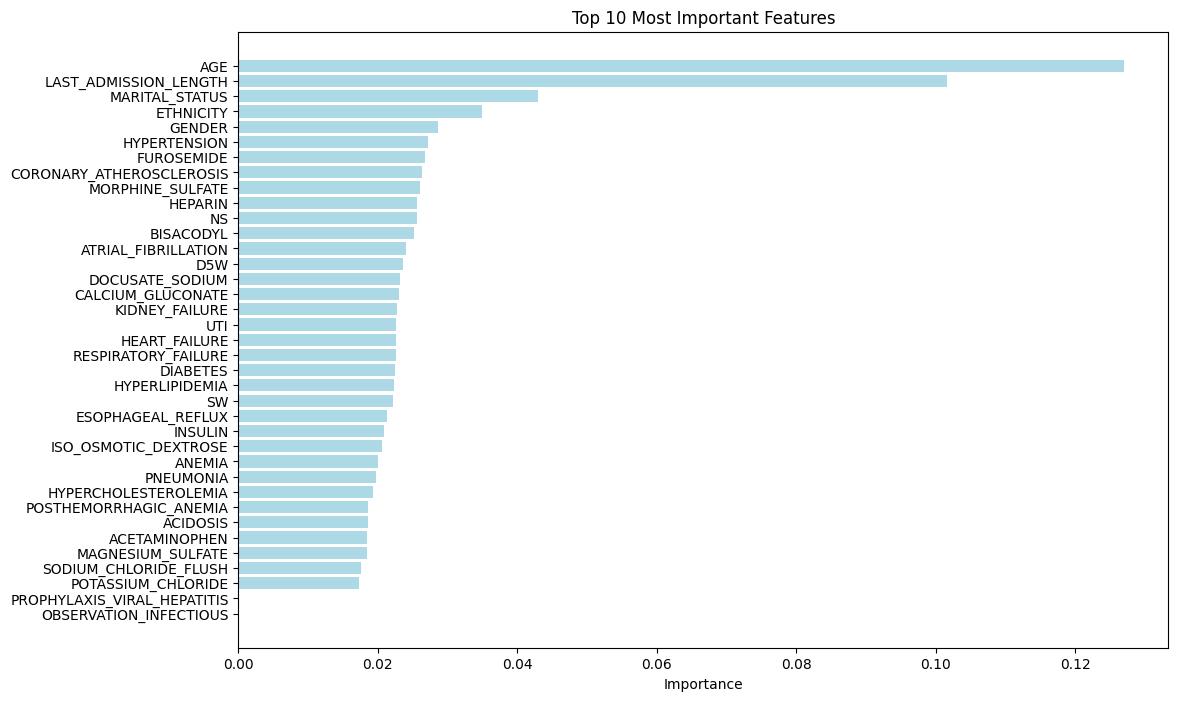

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = rf_grid_search.best_estimator_.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightblue')
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()

### VITAL SIGNS

In [30]:
import pandas as pd 
data = pd.read_csv('C:\\Users\\lclai\\Desktop\\data_dementia\\clean\\vitalsigns.csv')

#undersampling

import pandas as pd

df_alzheimer = data[data['DEMENTIA'] == 1]
df_no_alzheimer = data[data['DEMENTIA'] == 0]

df_no_alzheimer_sampled = pd.DataFrame()

for (age, gender), group in df_alzheimer.groupby(['AGE', 'GENDER']):
 
    matched_controls = df_no_alzheimer[(df_no_alzheimer['AGE'] == age) & (df_no_alzheimer['GENDER'] == gender)]
    
    if len(matched_controls) > len(group):
        matched_controls = matched_controls.sample(n=len(group), random_state=42)
    
    df_no_alzheimer_sampled = pd.concat([df_no_alzheimer_sampled, matched_controls])

df_balanced = pd.concat([df_alzheimer, df_no_alzheimer_sampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# outliers from numerical values

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_balanced = remove_outliers_iqr(df_balanced, 'AGE')
df_balanced = remove_outliers_iqr(df_balanced, 'LAST_ADMISSION_LENGTH')
df_balanced = remove_outliers_iqr(df_balanced, 'HEART_RATE')
df_balanced = remove_outliers_iqr(df_balanced, 'RESPIRATORY_RATE')
df_balanced = remove_outliers_iqr(df_balanced, 'DIASTOLIC_BP')
df_balanced = remove_outliers_iqr(df_balanced, 'SYSTOLIC_BP')
df_balanced = remove_outliers_iqr(df_balanced, 'MEAN_BP')
df_balanced = remove_outliers_iqr(df_balanced, 'OXYGEN_SATURATION')

binary = ['GENDER', 'DEMENTIA', 'HYPERTENSION',
       'CORONARY_ATHEROSCLEROSIS', 'ATRIAL_FIBRILLATION', 'HEART_FAILURE',
       'KIDNEY_FAILURE', 'HYPERLIPIDEMIA', 'DIABETES', 'RESPIRATORY_FAILURE',
       'UTI', 'PROPHYLAXIS_VIRAL_HEPATITIS', 'OBSERVATION_INFECTIOUS',
       'HYPERCHOLESTEROLEMIA', 'ESOPHAGEAL_REFLUX', 'ANEMIA', 'PNEUMONIA',
       'POSTHEMORRHAGIC_ANEMIA', 'ACIDOSIS', 'LAST_ADMISSION_LENGTH',
       'ETHNICITY', 'MARITAL_STATUS', 'POTASSIUM_CHLORIDE',
       'SODIUM_CHLORIDE_FLUSH', 'ACETAMINOPHEN', 'MAGNESIUM_SULFATE',
       'INSULIN', 'HEPARIN', 'DOCUSATE_SODIUM', 'D5W', 'ISO_OSMOTIC_DEXTROSE',
       'MORPHINE_SULFATE', 'NS', 'SW', 'FUROSEMIDE', 'CALCIUM_GLUCONATE',
       'BISACODYL']
categorical = ['ETHNICITY','MARITAL_STATUS']
numerical = ['LAST_ADMISSION_LENGTH','AGE','HEART_RATE', 'RESPIRATORY_RATE', 'DIASTOLIC_BP',
       'SYSTOLIC_BP', 'MEAN_BP', 'OXYGEN_SATURATION']

from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
scaler = StandardScaler()

for col in binary + categorical:
    df_balanced[col] = le.fit_transform(df_balanced[col]) 

df_balanced[numerical] = scaler.fit_transform(df_balanced[numerical])

In [38]:
from sklearn.model_selection import train_test_split

y = df_balanced['DEMENTIA']  
X = df_balanced.drop(columns=['DEMENTIA','OXYGEN_SATURATION','DIASTOLIC_BP','SYSTOLIC_BP']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [59]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k_best = SelectKBest(score_func=f_classif, k=8)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_param_grid = {
    'xgb__n_estimators': [3, 5, 15, 30],
    'xgb__max_depth': [3, 6, 10, 20],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2],
}

pipeline = Pipeline([
    ('feature_selection', k_best),
    ('xgb', xgb_model)
])

xgb_grid_search = GridSearchCV(pipeline, xgb_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

print("Best parameters found: ", xgb_grid_search.best_params_)
print(f"XGB Forest AUC: {xgb_grid_search.best_score_}")

Best parameters found:  {'xgb__colsample_bytree': 0.6, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 15, 'xgb__subsample': 0.6}
XGB Forest AUC: 0.7916666666666667


c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11 12 23 24 26 27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [60]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_proba = xgb_grid_search.best_estimator_.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc}")

AUC: 0.6160714285714286


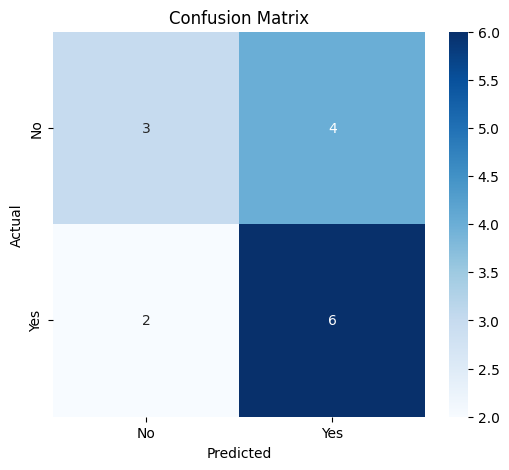

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.60      0.75      0.67         8

    accuracy                           0.60        15
   macro avg       0.60      0.59      0.58        15
weighted avg       0.60      0.60      0.59        15

AUC: 0.6160714285714286


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_proba = xgb_grid_search.best_estimator_.predict_proba(X_test)[:, 1]  

y_pred = (y_proba >= 0.5).astype(int)  

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc}")

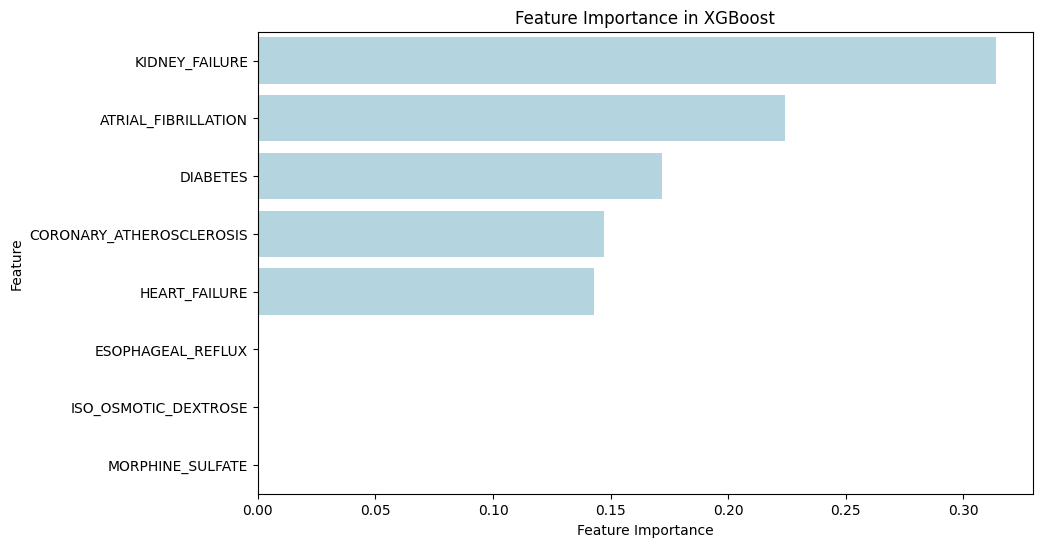

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

best_pipeline = xgb_grid_search.best_estimator_
xgb_best = best_pipeline.named_steps["xgb"]

feature_selector = best_pipeline.named_steps["feature_selection"]

selected_features = X_train.columns[feature_selector.get_support()]

feature_importances = xgb_best.feature_importances_

importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], color='lightblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost")
plt.show()
